# NHEFS Dataset
**NHANS (National Health and Nutrition Examionation Survey) Epidemiologic Followup Study**

The effect of smoking on health measurements was a decades-long debate. 
As Judea Pearl puts it, it was "probably the highest-profile medical question of the century".
The debate has divided not only the public across the US, but also physicians, epidemiologists and statisticians alike. 
Many known academic figures had took stand in this debate, researchers like 
[Abraham Lilienfeld](https://en.wikipedia.org/wiki/Abraham_Lilienfeld), 
[Austin Bradford Hill](https://en.wikipedia.org/wiki/Austin_Bradford_Hill), 
[Richard Doll](https://en.wikipedia.org/wiki/Richard_Doll), and even 
[Ronald Fisher](https://en.wikipedia.org/wiki/Ronald_Fisher).

In fact, since a randomized control trial on the issue was always regraded unethical, discovering the detrimintal effects of smoking is one of the most known examples of deriving a causal effect from observational studies.
If you believe smoking is not good for your health, you must also believe in causal inference.

In this example we will analyze the effect of smoking cessation on weight gain from real-world data.
People have noticed that that smoking cessation was associated with positive weight gaining.
Formaly, the hypothesis made was that people who quit smoking gain more weight than they would have if they would've kept smoking.
Actually, this association was used by pro-smoking advocators as the adverse effects of higher BMI (due to weught gain) have masked the positive effects that quitters benefitted from.

To quantify the effect of smoking cessation on weight gain, we will use data from the NHEFS. The NHANS (National Health and Nutrition Examionation Survey) Epidemiologic Followup Study (NHEFS) is a national longitudinal study that was jointly initiated by the American National Center for Health Statistics and the American National Institute on Aging.  
The study was designed to follow up on smokers, whom some of which quit, and record their weight (among other measurements) for a period of 11 years: from 1971 to 1982.  
We will follow an analysis suggested by Hernán and Robins in their [Causal Inference book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/) to answer the question how much smoking cessation contributes to weight gain in the population.

## The Data
First, let's download the dataset from the [Causal Inference book's](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/) webpage.

In [1]:
import pandas as pd
nhefs = pd.read_csv("https://cdn1.sph.harvard.edu/wp-content/uploads/sites/1268/1268/20/nhefs.csv")
print(nhefs.shape)
nhefs.head()

(1629, 64)


,seqn,qsmk,death,yrdth,modth,dadth,sbp,dbp,sex,age,...,birthcontrol,pregnancies,cholesterol,hightax82,price71,price82,tax71,tax82,price71_82,tax71_82
0,233,0,0,NaN,NaN,NaN,175.0,96.0,0,42,...,2,NaN,197.0,0.0,2.183594,1.739990,1.102295,0.461975,0.443787,0.640381
1,235,0,0,NaN,NaN,NaN,123.0,80.0,0,36,...,2,NaN,301.0,0.0,2.346680,1.797363,1.364990,0.571899,0.549316,0.792969
2,244,0,0,NaN,NaN,NaN,115.0,75.0,1,56,...,0,2.0,157.0,0.0,1.569580,1.513428,0.551270,0.230988,0.056198,0.320251
3,245,0,1,85.0,2.0,14.0,148.0,78.0,0,68,...,2,NaN,174.0,0.0,1.506592,1.451904,0.524902,0.219971,0.054794,0.304993
4,252,0,0,NaN,NaN,NaN,118.0,77.0,0,40,...,2,NaN,216.0,0.0,2.346680,1.797363,1.364990,0.571899,0.549316,0.792969


We can see the dataset has 1629 inidividuals in it.  

### Restriction criteria
Since the study focused on smokers, some also elderly, not all of the participants have survived the entire 11 years of follow-up period.
Although not the best practice in causal analysis, we will, for the sake of simplicity, discard from the dataset individuals whom we don't have their weight measured at the end period.

In [2]:
nhefs = nhefs.dropna(subset=["wt82"])  # weight meausred at 1982 - the end of the followup period
nhefs.shape

(1566, 64)

### Variables selection
Second, for our analysis to be accurate, we must identify the variables that act as confounders - meaning, the variables that affect both the outcome and the treatment assignment.  
For example, *age* of participants can affect both the outcome (weight), as people, on average, increase their weight as they grow older (this has several physiological reasons, such as change in metabolism). However, age can also effect the treatment (smoking cessation) as we can hypothesis that older people will be less likely to change their habits.  
Another example can be the *education level* of participants. More educated people might more prone to quit smoking (as they may be more exposed to the debate and understand the risks depicted in the arguments), but they also might be more conscious to the benefits of healthier food which in turn reduce the weight they gain over the years.

In [3]:
confounders = ["active",          # Measure of daily activity on 1971.
               "age",             # Age in 1971.
               "education",       # Amount of education in 1971: from 8th-grade to college level education.
               "exercise",        # Measure of recreational excercise.
               "race",            # Caucasian or not.
               "sex",             # Female or male.
               "smokeintensity",  # Number of Cigarettes smoked per day in 1971.  
               "smokeyrs",        # Years of smoking.
               "wt71"]            # Weight in Kilograms in 1971.
X = nhefs[confounders]
print(X.shape)
X.head()

(1566, 9)


,active,age,education,exercise,race,sex,smokeintensity,smokeyrs,wt71
0,0,42,1,2,1,0,30,29,79.04
1,0,36,2,0,0,0,20,24,58.63
2,0,56,2,2,1,1,20,26,56.81
3,1,68,1,2,1,0,3,53,59.42
4,1,40,2,1,0,0,20,19,87.09


We continue to define our input matrix for the regression analysis:   
We square our continuous variables and encode the categorical ones using a one-hot encoding scheme.

In [4]:
X = pd.get_dummies(X, columns=["active", "education", "exercise"], drop_first=True)
X = X.join(X[['age', 'wt71', 'smokeintensity', 'smokeyrs']]**2, rsuffix="^2")
X.head()

,age,race,sex,smokeintensity,smokeyrs,wt71,active_1,active_2,education_2,education_3,education_4,education_5,exercise_1,exercise_2,age^2,wt71^2,smokeintensity^2,smokeyrs^2
0,42,1,0,30,29,79.04,0,0,0,0,0,0,0,1,1764,6247.3216,900,841
1,36,0,0,20,24,58.63,0,0,1,0,0,0,0,0,1296,3437.4769,400,576
2,56,1,1,20,26,56.81,0,0,1,0,0,0,0,1,3136,3227.3761,400,676
3,68,1,0,3,53,59.42,1,0,0,0,0,0,0,1,4624,3530.7364,9,2809
4,40,0,0,20,19,87.09,1,0,1,0,0,0,1,0,1600,7584.6681,400,361


Lastly, we extract our treatment variable `qsmk` (quit smoking), and our outcome variable `wt82_71` (the difference in participants' weight between 1982 and 1971).

In [5]:
a = nhefs["qsmk"]
y = nhefs["wt82_71"]
pd.concat([a, y], axis="columns").head()

,qsmk,wt82_71
0,0,-10.093960
1,0,2.604970
2,0,9.414486
3,0,4.990117
4,0,4.989251


## The Model
After defining the confounders and further building our design matrix `X`, we can continue to define the causal model.

In this case we will use an Inverse Treatment Probability Weighting (IPTW, or IPW) causal model.  
Briefly, this model will model the probability of a participants' to quit smoking and use it to emulate two equal-sized populations: one of quitters and another of persisters. 
In this synthetic population, we could use the actual change in weight to estimate what would have happen if everyone were to quit or everyone were to persist smoking.

But first, we will need to use a machine learning model to estimate the propensity score $\Pr[A=1|X]$ - the probability of each participant to quit smoking.  
Following the design matrix we prepared above, and given the binary nature of our treatment, we will choose a logistic regression for this task.

In [6]:
from sklearn.linear_model import LogisticRegression

learner = LogisticRegression(penalty='none',  # No regularization, new in scikit-learn 0.21.*
                             solver='lbfgs',
                             max_iter=500)    # Increaed to achieve convergence with 'lbfgs' solver

Once we defined a learner, we can simply plug it into the causal model

In [7]:
from causallib.estimation import IPW

ipw = IPW(learner)

## Estimating Causal Effect
Once we defined the causal model (yes, that all it took), we can move on to estimate the effect of smoking cessation on weight gain.

First, we will fit our causal model.  
Second, we'll predict the potential outcomes: what would be the weight difference if everyone were to quit smoking or everyone were to persist smoking.  
Third, we will use the two potential outcomes to estimate the effect: the difference of the two potential outcomes.

In [8]:
ipw.fit(X, a)
outcomes = ipw.estimate_population_outcome(X, a, y)
effect = ipw.estimate_effect(outcomes[1], outcomes[0])

Checking the potential outcomes, we can see that the average difference in weight (across 11 years) if everyone would have quit smoking (`1`) is 5.28kg (11.64lbs) while the averge weight difference if everyone would have persist smoking (`0`, not quit) is 1.77kg (3.9lbs).

In [9]:
outcomes

0    1.765533
1    5.284088
dtype: float64

Therefore we can conclude that the average additive effect (`diff`) of smoking cessation on weight gain is 3.52kg (7.76lbs).

In [10]:
effect

diff    3.518555
dtype: float64

Indeed, we can conclude that smoking cessation accounts for a weight gain of 3.5kg on average.

### Unadjusted estimation
To compare, we can ask what conclusion would have we achive if we did not control for confounding.  
What would've been the result if we haven't adjusted for treatment assignment biases and treated the data as if it came from a randomized control trial?

In [11]:
from causallib.estimation import MarginalOutcomeEstimator

moe = MarginalOutcomeEstimator(None).fit(X, a, y)
outcomes = moe.estimate_population_outcome(X, a, y)
moe.estimate_effect(outcomes[1], outcomes[0])

diff    2.540581
dtype: float64

We can see that when failing to adjust for confounding factors, we underestimate the effect of smoking cessation on weight gain by 1kg (2.2lbs).

To see why, we can examine the how balanced were the treatment groups before and after IP weighting.  
We can check that using a _Love plot_, a graphical way to present distribution distance between the treated and untreated. It plots the standardized-mean-difference between the treatment groups for each covariate marginally.

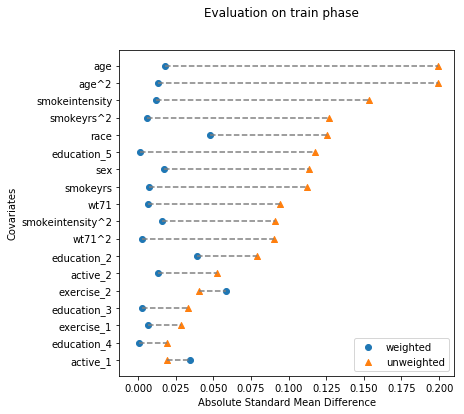

In [12]:
%matplotlib inline
from causallib.evaluation import PropensityEvaluator

evaluator = PropensityEvaluator(ipw)
evaluation_results = evaluator.evaluate_simple(X, a, y, plots=["covariate_balance_love"])

fig = evaluation_results.plots["covariate_balance_love"].get_figure()
fig.set_size_inches(6, 6)  # set a more compact size than default
fig;

We can see that prior to applying IP-weighting (orange triangles), the absolute mean-difference across treatment groups was up to 0.2 standard-deviations.  
This can easily bias a simple marginal comparison (i.e., simply check the outcome of treated against the outcome of untreated), since we see the groups are not marginally similar.  
For example, one could argue that difference in outcome is contributed to the fact that the two treatment groups differ on their average age.  
Since the treatment groups have different distribution of characteristics, it should be accounted for in a causal inference analysis, for-example: the importance-sampling-like scheme applied by the IPW model.  
After balancing (blue dots), we see that the marginal difference between the groups' covariate distribution is much smaller on average, suggesting that the IPW model had successfully balanced the dataset.